# Курсовой проект

**kaggle**
https://www.kaggle.com/alexandralazareva

### Задание для курсового проекта

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:
1. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту")
ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook 
с расширением ipynb). (Pull request не нужен, только ссылка ведущая на сам скрипт).
2. Приложить файл с названием по образцу SShirkin_predictions.csv
с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).
В файле с предсказаниями должна быть 5001 строка (шапка + 5000 предсказаний).

Сроки и условия сдачи:
Дедлайн: сдать проект нужно в течение 72 часов после начала Урока 10 ("Вебинар. Консультация по итоговому проекту").
Для успешной сдачи должны быть все предсказания (для 5000 квартир) и R2 должен быть больше 0.6.
При сдаче до дедлайна результат проекта может попасть в топ лучших результатов.
Повторная сдача и проверка результатов возможны только при условии предыдущей неуспешной сдачи.
Успешный проект нельзя пересдать в целях повышения результата.
Проекты, сданные после дедлайна или сданные повторно, не попадают в топ лучших результатов, но можно узнать результат.
В качестве итогового результата берется первый успешный результат, последующие успешные результаты не учитываются.

Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. При использовании статистик (среднее, медиана и т.д.) в качестве признаков,
лучше считать их на трейне, и потом на валидационных и тестовых данных не считать 
статистики заново, а брать их с трейна. Если хватает знаний, можно использовать кросс-валидацию,
но для сдачи этого проекта достаточно разбить данные из train.csv на train и valid.
9. Проект должен полностью отрабатывать за разумное время (не больше 10 минут),
поэтому в финальный вариант лучше не включать GridSearch с перебором 
большого количества сочетаний параметров.
10. Допускается применение моделей машинного обучения из библиотеки sklearn.

### Подключение библиотек и скриптов

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})

In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [5]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    """
    # дописать документация
    Выводить R2 и строит графики для оценки качества модели
    """
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))

    plt.figure(figsize=(18,10))
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

### Пути к директориям и файлам

In [6]:
TRAIN_DATASET_PATH = './project_data/train.csv' # y_train, y_valid
TEST_DATASET_PATH = './project_data/test.csv'

### Загрузка данных

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [7]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [8]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


**Оптимизация памяти**

In [9]:
# train_df.dtypes

In [10]:
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


In [11]:
# train_df.dtypes

In [12]:
#test_df.dtypes

In [13]:
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.22 MB
Decreased by 70.3%


In [14]:
#test_df.dtypes

### Обзор данных

**Целевая переменная**

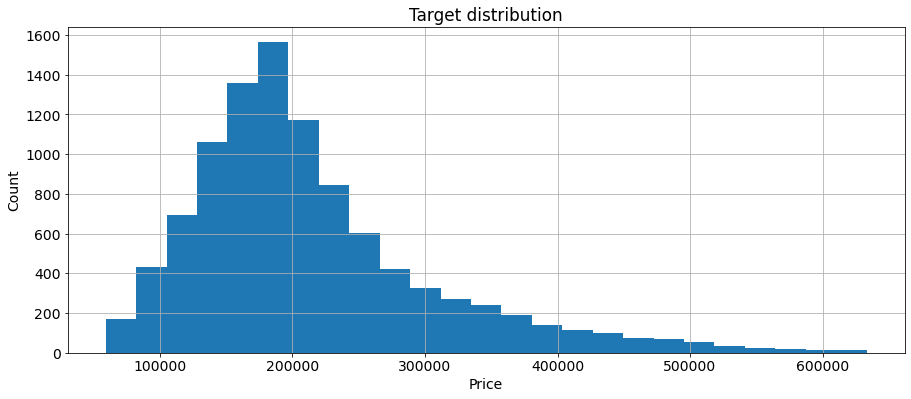

In [15]:
plt.figure(figsize = (15, 6))

train_df['Price'].hist(bins=25)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

**Количественные переменные**

In [16]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Id,10000.0,8383.407700,4859.019020,0.000000,4169.500000,8394.500000,12592.500000,1.679800e+04
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,2.090000e+02
Rooms,10000.0,1.890500,0.839522,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315720,21.058716,1.136859,41.774879,52.513309,65.900627,6.410652e+02
LifeSquare,7887.0,37.199665,86.241219,0.370619,22.769833,32.781261,45.128803,7.480592e+03
KitchenSquare,10000.0,6.273300,28.560839,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.776200,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218670e-01


**Категориальные переменные**

In [17]:
cat_colnames = train_df.select_dtypes(include='category').columns.tolist()
cat_colnames

['Ecology_2', 'Ecology_3', 'Shops_2']

In [18]:
for cat_colname in cat_colnames: # [2:]:
    print(str(cat_colname) + '\n\n' + str(train_df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Ecology_2

B    9903
A      97
Name: Ecology_2, dtype: int64
****************************************************************************************************

Ecology_3

B    9725
A     275
Name: Ecology_3, dtype: int64
****************************************************************************************************

Shops_2

B    9175
A     825
Name: Shops_2, dtype: int64
****************************************************************************************************



### Обработка выбросов

**Средняя цена по району**

In [19]:
# med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
#                       .rename(columns={'Price':'MedPriceByDistrict'})
#
# med_price_by_district.head()

**Rooms**

In [20]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

In [21]:
# train_df[train_df['Rooms'] == 6]

In [22]:
train_df.loc[train_df['Rooms'] == 19, 'Rooms'] = 1

In [23]:
train_df.loc[train_df['Rooms'] == 10, 'Rooms'] = 2

In [24]:
#train_df.loc[train_df['Rooms'] == 6, 'Rooms'] = 2

In [25]:
train_df.loc[train_df['Id'] == 3224, 'Rooms'] = 2
train_df.loc[train_df['Id'] == 3159, 'Rooms'] = 2

In [26]:
train_df.loc[train_df['Id'] == 7317, 'Rooms'] = 1

In [27]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 3

In [28]:
train_df['Rooms'] = train_df['Rooms'].astype(int)

**Средняя цена по району, обновление с учетом исправления количества комнат, добавление в выборку**

In [29]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                       .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1,142799.437500
1,0,2,176210.812500
2,0,3,300610.375000
3,1,1,146574.015625
4,1,2,202706.093750


In [30]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,MedPriceByDistrict
0,11809,27,3,115.027313,NaN,10.0,4,10.0,2014,0.075424,...,B,11,3097,0,NaN,0,0,B,305018.875000,214532.578125
1,3013,22,1,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,B,30,6207,1,1183.0,1,0,B,177734.546875,146032.828125
2,8215,1,3,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,B,33,5261,0,240.0,3,1,B,282078.718750,244005.281250
3,2352,1,1,40.409908,NaN,1.0,10,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,168106.000000,146574.015625
4,13866,94,2,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,B,33,8667,2,NaN,0,6,B,343995.093750,201584.437500


**HouseYear**

In [31]:
train_df['HouseYear'].value_counts().sort_index()

1910          1
1912          2
1914          1
1916          1
1917          3
           ... 
2018        175
2019         79
2020         19
4968          1
20052011      1
Name: HouseYear, Length: 97, dtype: int64

In [32]:
train_df.loc[train_df['HouseYear'] == 4968, 'HouseYear'] = 1968

In [33]:
train_df.loc[train_df['HouseYear'] == 20052011, 'HouseYear'] = 2005

**Floor / HouseFloor**

In [34]:
floors = train_df[train_df['Floor'] > train_df['HouseFloor']][train_df['HouseFloor'] == 0]
floors['Floor'].value_counts().sort_index()

1      7
2     16
3     17
4     24
5     21
6     16
7     23
8     13
9     30
10    10
11    14
12    12
13    12
14    13
15     5
16     7
17     7
18     5
19     4
20     3
21     1
22     1
23     2
24     2
25     3
26     1
Name: Floor, dtype: int64

In [35]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['Floor'] 
train_df[train_df['Floor'] > train_df['HouseFloor']].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,MedPriceByDistrict
17,1190,8,2,49.396000,28.299601,5.0,6,5.0,1962,0.458174,...,A,26,4439,1,1130.0,1,5,B,186971.921875,200777.312500
19,367,45,1,42.367290,40.012527,1.0,16,14.0,2015,0.195781,...,B,23,5212,6,NaN,3,2,B,250466.984375,234713.140625
21,8471,20,3,75.611061,47.494621,8.0,11,9.0,1976,0.019509,...,B,37,7687,11,176.0,5,5,B,366916.250000,390411.031250
25,4521,6,2,65.409966,NaN,1.0,18,1.0,1977,0.243205,...,B,5,1564,0,540.0,0,0,B,191205.265625,178486.390625
26,8553,88,3,83.262527,4.769175,1.0,13,1.0,1977,0.127376,...,B,43,8429,3,NaN,3,9,B,410883.906250,289588.937500


In [36]:
#train_df['HouseFloor'].value_counts().sort_index()

In [37]:
#train_df[train_df['HouseFloor'] == 117]

In [38]:
train_df.loc[train_df['HouseFloor'] == 117, 'HouseFloor'] = 17

In [39]:
#train_df[train_df['HouseFloor'] == 99]

In [40]:
train_df.loc[train_df['HouseFloor'] == 99, 'HouseFloor'] = 17

In [41]:
train_df['Floor'].value_counts().sort_index()

1     235
2     588
3     872
4     949
5     876
6     802
7     759
8     643
9     604
10    553
11    457
12    438
13    398
14    362
15    287
16    290
17    256
18    185
19    121
20     68
21     59
22     54
23     25
24     53
25     34
26     18
27      5
28      3
31      1
32      2
33      1
37      1
42      1
Name: Floor, dtype: int64

In [42]:
#median_house_floor = train_df.groupby(['HouseYear', 'DistrictId'], as_index=False).agg({'HouseFloor':'median'})\
#                        .rename(columns={'HouseFloor':'MedianHouseFloor'})

In [43]:
# median_house_floor[median_house_floor['DistrictId'] == 38 ]
#train_df.loc[train_df['Id'] == 37, 'HouseFloor'] = 17
train_df.loc[train_df['Id'] == 370, 'Floor'] = 25
train_df.loc[train_df['Id'] == 1471, 'Floor'] = 25

In [44]:
#train_df[train_df['Floor'] == 25]

In [45]:
train_df.loc[train_df['Floor'] == 27, 'HouseFloor'] = 25

In [46]:
train_df.loc[train_df['Floor'] == 27, 'Floor'] = 25

In [47]:
train_df_1977_lst = [9021, 5976, 10193, 1636, 13202]
# не сохранила как собрала

In [48]:
#train_df_1977['Id'].tolist()

In [49]:
#train_df[train_df['Id'].isin(train_df_1977['Id'].tolist())]
train_df[train_df['Id'].isin(train_df_1977_lst)].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,MedPriceByDistrict
1465,9021,23,1,103.744171,105.338394,1.0,26,25.0,1977,0.075779,...,B,6,1437,3,NaN,0,2,B,223249.328125,102069.273438
4362,5976,6,3,103.297935,NaN,0.0,26,25.0,1977,0.243205,...,B,5,1564,0,540.0,0,0,B,271249.531250,215577.656250
8706,10193,1,1,47.293594,NaN,1.0,26,24.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,163719.906250,146574.015625
8885,1636,30,2,60.185452,NaN,1.0,26,24.0,1977,0.000078,...,B,22,6398,141,1046.0,3,23,B,177829.812500,177914.718750
9087,13202,34,2,62.874317,NaN,1.0,26,1.0,1977,0.069753,...,B,53,13670,4,NaN,1,11,B,279097.875000,262469.687500


In [50]:
train_df.loc[train_df['Id'].isin(train_df_1977_lst), 'HouseFloor'] = 26

In [51]:
train_df[train_df['Floor'] == 26][train_df['Floor']>train_df['HouseFloor'] ].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,MedPriceByDistrict
258,4280,34,2,61.334969,4.091945,1.0,26,1.0,2014,0.069753,...,B,53,13670,4,NaN,1,11,B,286564.437500,262469.68750
4820,15303,48,3,83.866173,NaN,1.0,26,1.0,2014,0.041125,...,B,46,9515,5,NaN,1,10,B,468595.031250,422486.87500
4900,4145,96,3,90.055229,47.860229,11.0,26,24.0,2005,0.041116,...,B,53,14892,4,NaN,1,4,B,441108.906250,301993.31250
4983,8582,29,3,80.838371,45.049297,8.0,26,25.0,2010,0.069660,...,B,31,6119,4,NaN,1,2,B,256658.671875,275730.65625
5631,716,113,3,125.287186,127.477135,19.0,26,24.0,2017,0.050756,...,B,24,5469,1,145.0,0,1,B,522197.031250,283417.87500


In [52]:
train_df.loc[train_df['Id'].isin(train_df[train_df['Floor'] == 26][train_df['Floor']>train_df['HouseFloor']]['Id'].tolist()), 'HouseFloor'] = 26

In [53]:
train_df.loc[train_df['Floor']>train_df['HouseFloor'], 'Floor'] = train_df['HouseFloor']

In [54]:
#train_df.describe().transpose()

In [55]:
#train_df.dtypes

In [56]:
train_df['HouseFloor'] = train_df['HouseFloor'].astype(int)

In [57]:
train_df['Floor'] = train_df['Floor'].astype(int)

In [58]:
#train_df.dtypes

**Square, LifeSquare, KitchenSquare**

In [59]:
train_df[train_df['KitchenSquare']< 3.5].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,MedPriceByDistrict
3,2352,1,1,40.409908,NaN,1.0,10,22,1977,0.007122,...,B,1,264,0,NaN,0,1,B,168106.000000,146574.015625
8,9951,1,1,46.887894,44.628132,1.0,12,20,1977,0.007122,...,B,1,264,0,NaN,0,1,B,160400.406250,146574.015625
9,8094,6,3,79.867477,75.085129,1.0,3,17,2014,0.243205,...,B,5,1564,0,540.0,0,0,B,194756.031250,215577.656250
18,4581,1,1,47.582481,NaN,1.0,16,16,1977,0.007122,...,B,1,264,0,NaN,0,1,B,128803.593750,146574.015625
19,367,45,1,42.367290,40.012527,1.0,14,14,2015,0.195781,...,B,23,5212,6,NaN,3,2,B,250466.984375,234713.140625


In [60]:
train_df.loc[train_df['KitchenSquare'] < 4, 'KitchenSquare'] = 4

In [61]:
train_df['KitchenSquare'].value_counts().sort_index()

4.0       3222
5.0       1169
6.0       1038
7.0        609
8.0       1306
9.0        843
10.0      1075
11.0       233
12.0       249
13.0        67
14.0        51
15.0        31
16.0        16
17.0        12
18.0         6
19.0        11
20.0        14
21.0         1
22.0         3
23.0         1
25.0         2
26.0         1
27.0         1
29.0         1
30.0         2
31.0         1
32.0         2
35.0         1
36.0         1
37.0         2
39.0         1
40.0         1
41.0         2
42.0         1
43.0         2
48.0         1
51.0         2
53.0         1
54.0         1
58.0         2
60.0         1
62.0         1
63.0         1
66.0         1
72.0         1
73.0         1
75.0         1
78.0         1
84.0         1
96.0         1
112.0        2
123.0        1
1970.0       1
2014.0       1
Name: KitchenSquare, dtype: int64

In [62]:
train_df[train_df['KitchenSquare'] + train_df['KitchenSquare']> train_df['Square'] ]\
[train_df['KitchenSquare'] > 20][train_df['Rooms'] == 1][train_df['LifeSquare'] /train_df['Square'] < 0.6].head(20)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,MedPriceByDistrict
755,15781,10,1,35.813564,19.953993,35.0,6,14,1971,0.282798,...,B,33,8667,2,NaN,0,6,B,164306.312500,167742.765625
2785,6569,27,1,38.220257,18.716856,84.0,4,17,2018,0.011654,...,B,4,915,0,NaN,0,0,B,99079.960938,118309.312500
3228,6708,48,1,42.069359,22.487740,39.0,1,10,2010,0.041125,...,B,46,9515,5,NaN,1,10,B,200021.828125,206779.578125
5273,13703,42,1,38.071693,19.723547,73.0,9,10,2006,0.158249,...,B,21,5731,0,NaN,1,0,B,160488.031250,161627.093750
5695,11624,46,1,42.983284,24.224436,37.0,15,16,1983,0.188784,...,B,31,6137,4,NaN,0,1,B,198450.734375,172887.531250
6079,448,48,1,41.186905,1.626502,41.0,1,1,1977,0.041125,...,B,46,9515,5,NaN,1,10,B,216882.265625,206779.578125
6505,14679,81,1,32.276665,19.278395,1970.0,1,1,1977,0.006076,...,B,30,5285,0,645.0,6,6,B,105539.554688,171517.718750


In [63]:
train_df.loc[train_df['Id'] == 448, 'LifeSquare'] = 20
train_df.loc[train_df['Id'] == 448, 'KitchenSquare'] = 16

In [64]:
id_to_chg = train_df[train_df['KitchenSquare'] + train_df['KitchenSquare']> train_df['Square'] ]\
[train_df['KitchenSquare'] > 20][train_df['Rooms'] == 1][train_df['LifeSquare'] /train_df['Square'] < 0.6]['Id'].tolist()
id_to_chg

[15781, 6569, 6708, 13703, 11624, 14679]

In [65]:
train_df.loc[train_df['Id'].isin(id_to_chg), 'KitchenSquare'] = train_df['Square'] -  train_df['LifeSquare'] - 10 

In [66]:
train_df[train_df['Id'].isin(id_to_chg)].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,MedPriceByDistrict
755,15781,10,1,35.813564,19.953993,5.859571,6,14,1971,0.282798,...,B,33,8667,2,NaN,0,6,B,164306.312500,167742.765625
2785,6569,27,1,38.220257,18.716856,9.503401,4,17,2018,0.011654,...,B,4,915,0,NaN,0,0,B,99079.960938,118309.312500
3228,6708,48,1,42.069359,22.487740,9.581619,1,10,2010,0.041125,...,B,46,9515,5,NaN,1,10,B,200021.828125,206779.578125
5273,13703,42,1,38.071693,19.723547,8.348146,9,10,2006,0.158249,...,B,21,5731,0,NaN,1,0,B,160488.031250,161627.093750
5695,11624,46,1,42.983284,24.224436,8.758848,15,16,1983,0.188784,...,B,31,6137,4,NaN,0,1,B,198450.734375,172887.531250


In [67]:
train_df[train_df['KitchenSquare'] + train_df['KitchenSquare']> train_df['Square'] ]\
[train_df['KitchenSquare'] > 20][train_df['Rooms'] == 1].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,MedPriceByDistrict
456,10546,62,1,46.013187,43.417042,43.0,4,17,2019,0.072158,...,B,2,629,1,NaN,0,0,A,113909.101562,129107.218750
2108,2271,27,1,43.292515,42.835644,40.0,11,11,2015,0.211401,...,B,9,1892,0,NaN,0,1,B,117296.171875,118309.312500
2702,1315,6,1,48.128113,45.023533,48.0,1,1,2013,0.243205,...,B,5,1564,0,540.0,0,0,B,146950.906250,130636.710938
4091,15466,88,1,42.357487,44.779713,41.0,10,19,2016,0.127376,...,B,43,8429,3,NaN,3,9,B,194525.109375,186517.656250
5033,16781,27,1,36.138409,36.710541,36.0,19,19,2017,0.072158,...,B,2,629,1,NaN,0,0,A,131742.531250,118309.312500


In [68]:
id_to_chg = train_df[train_df['KitchenSquare'] + train_df['KitchenSquare']> train_df['Square'] ]\
[train_df['KitchenSquare'] > 20][train_df['Rooms'] == 1]['Id'].tolist()
id_to_chg

[10546, 2271, 1315, 15466, 16781, 673, 9690, 14656]

In [69]:
train_df.loc[train_df['Id'].isin(id_to_chg), 'LifeSquare'] = train_df['Square'] *0.6

In [70]:
train_df.loc[train_df['Id'].isin(id_to_chg), 'KitchenSquare'] = train_df['Square'] -  train_df['LifeSquare'] - 10 

In [71]:
train_df[train_df['Id'].isin(id_to_chg)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,MedPriceByDistrict
456,10546,62,1,46.013187,27.607914,8.405273,4,17,2019,0.072158,...,B,2,629,1,NaN,0,0,A,113909.101562,129107.218750
2108,2271,27,1,43.292515,25.975510,7.317005,11,11,2015,0.211401,...,B,9,1892,0,NaN,0,1,B,117296.171875,118309.312500
2702,1315,6,1,48.128113,28.876869,9.251244,1,1,2013,0.243205,...,B,5,1564,0,540.0,0,0,B,146950.906250,130636.710938
4091,15466,88,1,42.357487,25.414494,6.942993,10,19,2016,0.127376,...,B,43,8429,3,NaN,3,9,B,194525.109375,186517.656250
5033,16781,27,1,36.138409,21.683046,4.455362,19,19,2017,0.072158,...,B,2,629,1,NaN,0,0,A,131742.531250,118309.312500
6293,673,27,1,54.418213,32.650928,11.767284,10,17,2017,0.072158,...,B,2,629,1,NaN,0,0,A,133273.640625,118309.312500
8855,9690,27,1,40.081043,24.048628,6.032415,18,19,2019,0.211401,...,B,9,1892,0,NaN,0,1,B,93218.648438,118309.312500
9520,14656,62,1,47.100719,28.260433,8.840286,1,1,2014,0.072158,...,B,2,629,1,NaN,0,0,A,108337.484375,129107.218750


In [72]:
train_df[train_df['KitchenSquare'] + train_df['KitchenSquare']> train_df['Square'] ]\
[train_df['KitchenSquare'] > 20][train_df['Rooms'] == 2][train_df['LifeSquare'] /train_df['Square'] < 0.6].head(20)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,MedPriceByDistrict
5792,6508,23,2,67.146049,33.959152,63.0,5,17,2019,0.034656,...,B,0,168,0,NaN,0,0,B,193130.578125,142883.015625
7601,12666,34,2,60.603363,2.400832,58.0,14,22,1977,0.069753,...,B,53,13670,4,NaN,1,11,B,261733.468750,262469.687500


In [73]:
train_df.loc[train_df['Id'] == 12666, 'LifeSquare'] = train_df['Square']*0.6
train_df.loc[train_df['Id'] == 12666, 'KitchenSquare'] = train_df['Square']- train_df['LifeSquare']-15
train_df.loc[train_df['Id'] == 6508, 'KitchenSquare'] = train_df['Square']- train_df['LifeSquare']-15

In [74]:
train_df[train_df['Id'] == 12666]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,MedPriceByDistrict
7601,12666,34,2,60.603363,36.362019,9.241344,14,22,1977,0.069753,...,B,53,13670,4,NaN,1,11,B,261733.46875,262469.6875


In [75]:
train_df[train_df['KitchenSquare'] + train_df['KitchenSquare']> train_df['Square'] ]\
[train_df['KitchenSquare'] > 20][train_df['Rooms'] == 2].head(20)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,MedPriceByDistrict
682,16593,52,2,64.859245,NaN,62.0,15,17,1977,0.371149,...,B,34,7065,1,750.0,2,5,B,185993.468750,169188.937500
2831,12507,54,2,79.810532,79.578964,78.0,10,15,2014,0.006076,...,B,30,5285,0,645.0,6,6,B,438708.718750,364374.531250
3240,2371,27,2,68.841072,64.234955,66.0,2,2,2014,0.017647,...,B,2,469,0,NaN,0,0,B,189244.250000,165478.890625
3586,12918,23,2,51.440464,53.134243,51.0,3,17,2017,0.005767,...,B,1,388,0,NaN,0,0,B,88150.015625,142883.015625
3725,299,27,2,66.787521,64.616661,60.0,14,20,2015,0.017647,...,B,2,469,0,NaN,0,0,B,179466.093750,165478.890625
5663,11739,27,2,61.070297,59.845093,58.0,8,17,2016,0.072158,...,B,2,629,1,NaN,0,0,A,212188.953125,165478.890625
7080,4265,161,2,53.216778,32.644859,53.0,7,17,1994,0.000699,...,B,14,3369,24,4129.0,0,3,B,261125.671875,219620.625000
8329,7162,34,2,56.738762,57.510395,54.0,26,26,2016,0.069753,...,B,53,13670,4,NaN,1,11,B,244220.625000,262469.687500


In [76]:
id_to_chg = train_df[train_df['KitchenSquare'] + train_df['KitchenSquare']> train_df['Square'] ]\
[train_df['KitchenSquare'] > 20][train_df['Rooms'] == 2]['Id'].tolist()
id_to_chg

[16593, 12507, 2371, 12918, 299, 11739, 4265, 7162]

In [77]:
train_df.loc[train_df['Id'].isin(id_to_chg), 'LifeSquare'] = train_df['Square']*0.6
train_df.loc[train_df['Id'].isin(id_to_chg), 'KitchenSquare'] = train_df['Square']- train_df['LifeSquare']-15

In [78]:
train_df[train_df['Id'].isin(id_to_chg)].head(20)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,MedPriceByDistrict
682,16593,52,2,64.859245,38.915550,10.943695,15,17,1977,0.371149,...,B,34,7065,1,750.0,2,5,B,185993.468750,169188.937500
2831,12507,54,2,79.810532,47.886322,16.924210,10,15,2014,0.006076,...,B,30,5285,0,645.0,6,6,B,438708.718750,364374.531250
3240,2371,27,2,68.841072,41.304646,12.536427,2,2,2014,0.017647,...,B,2,469,0,NaN,0,0,B,189244.250000,165478.890625
3586,12918,23,2,51.440464,30.864279,5.576185,3,17,2017,0.005767,...,B,1,388,0,NaN,0,0,B,88150.015625,142883.015625
3725,299,27,2,66.787521,40.072514,11.715008,14,20,2015,0.017647,...,B,2,469,0,NaN,0,0,B,179466.093750,165478.890625
5663,11739,27,2,61.070297,36.642181,9.428116,8,17,2016,0.072158,...,B,2,629,1,NaN,0,0,A,212188.953125,165478.890625
7080,4265,161,2,53.216778,31.930067,6.286711,7,17,1994,0.000699,...,B,14,3369,24,4129.0,0,3,B,261125.671875,219620.625000
8329,7162,34,2,56.738762,34.043259,7.695503,26,26,2016,0.069753,...,B,53,13670,4,NaN,1,11,B,244220.625000,262469.687500


In [79]:
train_df[train_df['KitchenSquare'] + train_df['KitchenSquare']> train_df['Square'] ]\
[train_df['KitchenSquare'] > 20][train_df['LifeSquare'] /train_df['Square']> 0.6].head(20)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,MedPriceByDistrict
286,2737,27,3,123.430069,125.806984,123.0,5,10,2015,0.017647,...,B,2,469,0,NaN,0,0,B,234194.84375,214532.578125
2454,12390,72,3,97.490677,99.323555,96.0,22,25,2019,0.210473,...,B,11,2398,2,1994.0,3,0,B,445074.96875,336533.687500
3956,4966,96,3,78.445679,47.146755,75.0,9,12,1977,0.041116,...,B,53,14892,4,NaN,1,4,B,290354.46875,301993.312500
5002,7441,62,3,114.734474,112.589081,112.0,3,3,2015,0.072158,...,B,2,629,1,NaN,0,0,A,315245.53125,213915.968750
7733,12552,58,3,116.405693,113.109650,112.0,3,3,2016,0.437885,...,B,23,5735,3,1084.0,0,5,B,296165.93750,240680.890625


In [80]:
train_df.loc[train_df['Id'] == 4966, 'KitchenSquare'] = train_df['Square']- train_df['LifeSquare']-15

In [81]:
id_to_chg = train_df[train_df['KitchenSquare'] + train_df['KitchenSquare']> train_df['Square'] ]\
[train_df['KitchenSquare'] > 20][train_df['Rooms'] == 3]['Id'].tolist()
id_to_chg

[2737, 16395, 12390, 7441, 12552]

In [82]:
train_df.loc[train_df['Id'].isin(id_to_chg), 'LifeSquare'] = train_df['Square']*0.7
train_df.loc[train_df['Id'].isin(id_to_chg), 'KitchenSquare'] = train_df['Square']- train_df['LifeSquare']-18

In [83]:
train_df[train_df['Id'].isin(id_to_chg)].head(20)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,MedPriceByDistrict
286,2737,27,3,123.430069,86.401047,19.029022,5,10,2015,0.017647,...,B,2,469,0,NaN,0,0,B,234194.84375,214532.578125
1728,16395,2,3,79.722244,55.805569,5.916676,12,16,1987,0.130618,...,B,39,10418,9,900.0,1,9,B,370148.62500,323304.625000
2454,12390,72,3,97.490677,68.243469,11.247208,22,25,2019,0.210473,...,B,11,2398,2,1994.0,3,0,B,445074.96875,336533.687500
5002,7441,62,3,114.734474,80.314133,16.420341,3,3,2015,0.072158,...,B,2,629,1,NaN,0,0,A,315245.53125,213915.968750
7733,12552,58,3,116.405693,81.483986,16.921707,3,3,2016,0.437885,...,B,23,5735,3,1084.0,0,5,B,296165.93750,240680.890625


In [84]:
train_df[train_df['KitchenSquare'] + train_df['KitchenSquare']> train_df['Square'] ].head(30)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,MedPriceByDistrict
161,6782,45,1,2.954309,5.257278,4.0,1,1,1977,0.195781,...,B,23,5212,6,NaN,3,2,B,438005.187500,234713.140625
328,4504,27,3,4.390331,5.610772,4.0,8,19,2016,0.211401,...,B,9,1892,0,NaN,0,1,B,161379.062500,214532.578125
1401,9487,5,1,5.129221,5.549458,4.0,1,1,1977,0.150818,...,B,16,3433,4,2643.0,4,5,B,369472.406250,226173.531250
4496,15744,34,1,1.988943,2.642219,4.0,4,4,1977,0.069753,...,B,53,13670,4,NaN,1,11,B,458378.781250,195428.250000
4800,7657,38,1,4.502784,4.618547,4.0,1,1,1977,0.060753,...,B,15,2787,2,520.0,0,7,B,483283.500000,247856.312500
5009,11526,27,1,4.633498,1.969969,4.0,1,1,1977,0.011654,...,B,4,915,0,NaN,0,0,B,107604.265625,118309.312500
7033,1748,88,2,5.497061,67.628716,4.0,22,22,1977,0.127376,...,B,43,8429,3,NaN,3,9,B,412511.093750,207534.656250
7470,14786,1,1,1.136859,4.525736,4.0,1,1,1977,0.007122,...,B,1,264,0,NaN,0,1,B,181434.828125,146574.015625
8572,10202,6,1,2.596351,4.604943,4.0,3,25,2014,0.243205,...,B,5,1564,0,540.0,0,0,B,137597.593750,130636.710938
8805,10527,27,1,4.380726,40.805836,4.0,10,17,2013,0.211401,...,B,9,1892,0,NaN,0,1,B,97560.718750,118309.312500


In [85]:
train_df.loc[train_df['Id'] == 4504, 'Square'] = train_df['Square']*10
train_df.loc[train_df['Id'] == 4504, 'LifeSquare'] = train_df['Square']-6

In [86]:
train_df.loc[train_df['Id'] == 12676, 'Square'] = train_df['LifeSquare']+ 6 + train_df['KitchenSquare']

In [87]:
train_df.loc[train_df['Id'] == 10527, 'Square'] = train_df['LifeSquare']+ 6 + train_df['KitchenSquare']

In [88]:
id_to_chg = train_df[train_df['KitchenSquare'] + train_df['KitchenSquare']> train_df['Square'] ]['Id'].tolist()
id_to_chg

[6782, 9487, 15744, 7657, 11526, 1748, 14786, 10202, 13265, 3224]

In [89]:
train_df = train_df.loc[train_df['Id'].isin(id_to_chg)==False]

In [90]:
#train_df.describe().transpose()

In [91]:
#train_df[train_df['LifeSquare'].isnull()].head(20)

In [92]:
train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare']=train_df['Square']- train_df['KitchenSquare']-10

In [93]:
#train_df[train_df['LifeSquare']< 15]

In [94]:
train_df.loc[train_df['LifeSquare']< 15, 'LifeSquare']=train_df['Square']- train_df['KitchenSquare']-6

In [95]:
#train_df[train_df['LifeSquare']< 15].head()

In [96]:
train_df[train_df['LifeSquare']< 15].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,MedPriceByDistrict
299,828,90,1,20.924927,10.924927,4.0,5,5,1968,0.265089,...,B,37,5288,0,1937.0,3,2,B,128808.085938,154613.203125
890,3732,112,1,20.213127,10.213127,4.0,5,9,1974,0.069660,...,B,31,6119,4,NaN,1,2,B,113050.226562,172108.093750
964,12079,130,1,25.410513,12.410513,7.0,10,16,1996,0.218440,...,B,21,4472,6,1450.0,4,7,A,119853.828125,172778.171875
1208,3072,129,1,25.543282,13.543282,6.0,5,5,1961,0.051942,...,B,17,4017,7,800.0,2,0,B,115342.226562,171918.406250
1717,9905,41,1,22.691542,12.691542,4.0,7,9,1972,0.175055,...,B,36,10055,3,NaN,1,0,B,136682.953125,173887.000000


In [97]:
train_df.loc[train_df['LifeSquare']< 15, 'LifeSquare']=train_df['Square']- train_df['KitchenSquare']-4

In [98]:
train_df[train_df['LifeSquare']< 15].head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,MedPriceByDistrict
299,828,90,1,20.924927,12.924927,4.0,5,5,1968,0.265089,...,B,37,5288,0,1937.0,3,2,B,128808.085938,154613.203125
890,3732,112,1,20.213127,12.213127,4.0,5,9,1974,0.069660,...,B,31,6119,4,NaN,1,2,B,113050.226562,172108.093750
964,12079,130,1,25.410513,14.410513,7.0,10,16,1996,0.218440,...,B,21,4472,6,1450.0,4,7,A,119853.828125,172778.171875
1717,9905,41,1,22.691542,14.691542,4.0,7,9,1972,0.175055,...,B,36,10055,3,NaN,1,0,B,136682.953125,173887.000000
2576,14642,90,1,22.682705,14.682705,4.0,5,5,1969,0.265089,...,B,37,5288,0,1937.0,3,2,B,118004.828125,154613.203125
5870,6927,21,1,16.117155,8.117155,4.0,2,5,1965,0.194489,...,B,47,8004,3,125.0,3,5,B,79913.265625,153921.406250
6379,6351,111,1,20.606762,12.606762,4.0,4,15,1975,0.135650,...,B,46,7960,6,350.0,3,11,B,108379.890625,184806.281250
6632,13685,0,1,17.498543,9.498543,4.0,5,5,1961,0.319809,...,B,25,4756,16,2857.0,5,8,B,88871.750000,142799.437500
8501,12927,62,2,17.414181,9.414181,4.0,4,20,1977,0.072158,...,B,2,629,1,NaN,0,0,A,180750.468750,178912.375000
9990,10635,21,1,18.983963,10.983963,4.0,1,5,1967,0.194489,...,B,47,8004,3,125.0,3,5,B,112411.218750,153921.406250


In [99]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,MedPriceByDistrict
count,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.00000,9990.000000,9990.000000,9990.000000,9990.000000,5199.000000,9990.000000,9990.000000,9990.000000,9990.000000
mean,8382.347948,50.424024,1.889590,56.378654,39.970913,6.749493,7.958759,12.842943,1984.86987,0.118888,24.695395,5353.810511,8.045345,1142.851685,1.319720,4.231932,214057.734375,211534.703125
std,4859.317204,43.595766,0.812556,20.987955,77.295555,2.859805,5.241863,6.335915,18.41691,0.119053,17.530649,4006.324039,23.842915,1021.532593,1.493565,4.807118,92772.031250,76578.843750
min,0.000000,0.000000,1.000000,16.117155,8.117155,2.998270,1.000000,1.000000,1910.00000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344,82342.773438
25%,4168.500000,20.000000,1.000000,41.788427,25.476802,4.000000,4.000000,9.000000,1974.00000,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153887.000000,165071.828125
50%,8393.500000,36.000000,2.000000,52.539537,34.295252,6.000000,7.000000,14.000000,1977.00000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192255.023438,195474.296875
75%,12591.750000,75.000000,2.000000,65.921076,47.744403,9.000000,11.000000,17.000000,2001.00000,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249095.574219,241068.906250
max,16798.000000,209.000000,6.000000,641.065186,7480.592285,43.000000,42.000000,48.000000,2020.00000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500,624156.000000


In [100]:
train_df[train_df['KitchenSquare']< 4].head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,MedPriceByDistrict
6505,14679,81,1,32.276665,19.278395,2.99827,1,1,1977,0.006076,...,B,30,5285,0,645.0,6,6,B,105539.554688,171517.71875


**Healthcare_1**

In [101]:
train_df.loc[train_df['Healthcare_1'].isnull(), 'Healthcare_1'] = train_df['Healthcare_1'].median()

In [102]:
#train_df.describe().transpose()

**Dummies**

In [103]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

### Отбор признаков

In [104]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'MedPriceByDistrict']

In [105]:
feature_names = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1']

new_feature_names = ['MedPriceByDistrict']

target_name = 'Price'

In [106]:
train_df.shape

(9990, 21)

In [107]:
test_df.shape

(5000, 19)

### Разбиение на train и test

In [108]:
X = train_df[feature_names + new_feature_names]
X.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,MedPriceByDistrict
0,27,3,115.027313,95.027313,10.0,4,10,2014,0.075424,11,3097,0,900.0,0,0,214532.578125
1,22,1,39.832523,23.169222,8.0,7,8,1966,0.118537,30,6207,1,1183.0,1,0,146032.828125
2,1,3,78.342216,47.671970,10.0,2,17,1988,0.025609,33,5261,0,240.0,3,1,244005.281250
3,1,1,40.409908,26.409908,4.0,10,22,1977,0.007122,1,264,0,900.0,0,1,146574.015625
4,94,2,64.285065,38.562515,9.0,16,16,1972,0.282798,33,8667,2,900.0,0,6,201584.437500


In [109]:
y = train_df[target_name]
y.head()

0    305018.875000
1    177734.546875
2    282078.718750
3    168106.000000
4    343995.093750
Name: Price, dtype: float32

### Построение модели

**Обучение и оценка модели**

In [110]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=True, random_state=50
)

In [111]:
rf_model = RandomForestRegressor(
    max_depth=12, min_samples_split=12, n_estimators=500, n_jobs=-1, random_state=50
)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=12, min_samples_split=12, n_estimators=500,
                      n_jobs=-1, random_state=50)

Train R2:	0.89
Test R2:	0.754


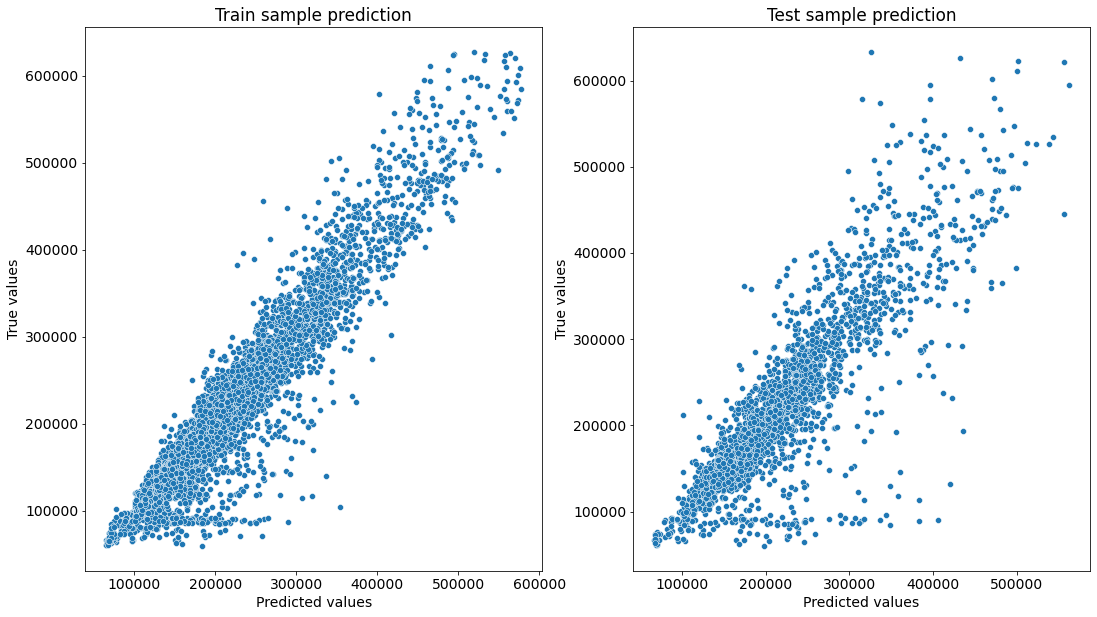

In [112]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

**Перекрёстная проверка**

In [113]:
cv_score = cross_val_score(
    rf_model,
    X.fillna(-9999),
    y, scoring='r2',
    cv=KFold(n_splits=5, shuffle=True, random_state=21)
)
cv_score

array([0.78247495, 0.75681661, 0.74413156, 0.7237855 , 0.75263268])

In [114]:
cv_score.mean(), cv_score.std()

(0.7519682610878659, 0.01902781081134811)

In [115]:
cv_score.mean() - cv_score.std(), cv_score.mean() + cv_score.std()

(0.7329404502765178, 0.7709960718992139)

**Важность признаков**

In [116]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
15,MedPriceByDistrict,0.701141
2,Square,0.098726
4,KitchenSquare,0.024589
6,HouseFloor,0.022239
3,LifeSquare,0.021763
11,Social_3,0.021509
7,HouseYear,0.020543
12,Healthcare_1,0.015068
10,Social_2,0.013031
9,Social_1,0.012392


## Формирование файла с прогнозами

In [117]:
test_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Id,5000.0,8412.595400,4832.674037,1.000000,4221.750000,8320.500000,12598.250000,16795.000000
DistrictId,5000.0,51.279200,44.179466,0.000000,21.000000,37.000000,77.000000,212.000000
Rooms,5000.0,1.910000,0.838586,0.000000,1.000000,2.000000,2.000000,17.000000
Square,5000.0,56.449512,19.092773,1.378543,41.906230,52.921339,66.285130,223.453690
LifeSquare,3959.0,36.158756,17.825274,0.333490,23.092026,32.925087,45.174091,303.071106
KitchenSquare,5000.0,5.976800,9.950069,0.000000,1.000000,6.000000,9.000000,620.000000
Floor,5000.0,8.632000,5.483228,1.000000,4.000000,7.000000,12.000000,78.000000
HouseFloor,5000.0,12.601000,6.789165,0.000000,9.000000,12.000000,17.000000,99.000000
HouseYear,5000.0,1984.392600,18.573149,1908.000000,1973.000000,1977.000000,2000.000000,2020.000000
Ecology_1,5000.0,0.119874,0.120070,0.000000,0.019509,0.072158,0.195781,0.521867


In [118]:
test_df['Ecology_2'] = test_df['Ecology_2'].replace(binary_to_numbers)
test_df['Ecology_3'] = test_df['Ecology_3'].replace(binary_to_numbers)
test_df['Shops_2'] = test_df['Shops_2'].replace(binary_to_numbers)

In [119]:
test_df.loc[test_df['Healthcare_1'].isnull(), 'Healthcare_1'] = test_df['Healthcare_1'].median()

In [120]:
test_df = test_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,MedPriceByDistrict
0,4567,44,1.0,36.847630,19.094183,5.0,5,9.0,1970,0.036122,1,1,24,4378,0,1036.0,1,1,1,171145.171875
1,5925,62,1.0,42.493908,42.568134,10.0,7,17.0,2017,0.072158,1,1,2,629,1,900.0,0,0,0,129107.218750
2,960,27,2.0,59.463676,NaN,9.0,19,19.0,1977,0.211401,1,1,9,1892,0,900.0,0,1,1,165478.890625
3,3848,23,3.0,49.646030,33.893826,6.0,2,2.0,1965,0.014073,1,1,2,475,0,900.0,0,0,1,166687.734375
4,746,74,1.0,53.837055,NaN,1.0,8,17.0,1977,0.309479,1,1,35,7715,4,990.0,0,6,1,165071.828125


In [121]:
#test_df[test_df['MedPriceByDistrict'].isnull()]['DistrictId'].value_counts()

In [122]:
med_price_by_district_id = med_price_by_district['DistrictId'].unique().tolist()

In [123]:
test_df[test_df['MedPriceByDistrict'].isnull()][test_df['DistrictId'].isin(med_price_by_district_id) == False]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,MedPriceByDistrict
1279,14939,210,2.0,54.953827,31.223917,6.0,3,10.0,1956,8.194346e-02,1,1,20,2738,20,900.0,1,4,1,NaN
1979,8845,203,2.0,50.417709,27.587971,7.0,5,4.0,1977,1.501689e-02,1,1,17,3079,59,2890.0,0,8,1,NaN
2280,9155,204,3.0,88.559334,62.854221,8.0,8,7.0,1918,3.731645e-02,1,1,32,6748,93,562.0,4,10,1,NaN
2609,14024,198,2.0,47.477280,31.069466,5.0,2,5.0,1970,6.076152e-03,1,1,30,5285,0,645.0,6,6,1,NaN
2674,15655,211,2.0,46.501556,32.276985,5.0,5,5.0,1965,1.800000e-09,1,1,16,3681,73,1815.0,2,5,1,NaN
3723,13382,206,2.0,46.047291,27.384090,6.0,5,7.0,1930,7.815280e-05,1,1,22,6398,141,1046.0,3,23,1,NaN
4807,15748,212,2.0,75.655182,36.877625,15.0,2,7.0,1929,0.000000e+00,1,1,8,1423,37,562.0,1,8,1,NaN
4836,16217,206,4.0,76.428429,50.344902,11.0,7,6.0,1912,4.203159e-02,1,1,37,6856,84,1940.0,2,5,1,NaN


In [124]:
med_price_by_district_no_room = train_df.groupby(['DistrictId'], as_index=False).agg({'Price':'median'})\
                       .rename(columns={'Price':'MedPriceByDistrict_NoRoom'})

med_price_by_district_no_room.head()

,DistrictId,MedPriceByDistrict_NoRoom
0,0,165963.062500
1,1,183663.437500
2,2,208539.500000
3,3,169094.015625
4,4,278639.468750


In [125]:
test_df = test_df.merge(med_price_by_district_no_room, on=['DistrictId'], how='left')
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,MedPriceByDistrict,MedPriceByDistrict_NoRoom
0,4567,44,1.0,36.847630,19.094183,5.0,5,9.0,1970,0.036122,...,1,24,4378,0,1036.0,1,1,1,171145.171875,208164.468750
1,5925,62,1.0,42.493908,42.568134,10.0,7,17.0,2017,0.072158,...,1,2,629,1,900.0,0,0,0,129107.218750,162067.281250
2,960,27,2.0,59.463676,NaN,9.0,19,19.0,1977,0.211401,...,1,9,1892,0,900.0,0,1,1,165478.890625,146247.609375
3,3848,23,3.0,49.646030,33.893826,6.0,2,2.0,1965,0.014073,...,1,2,475,0,900.0,0,0,1,166687.734375,113789.562500
4,746,74,1.0,53.837055,NaN,1.0,8,17.0,1977,0.309479,...,1,35,7715,4,990.0,0,6,1,165071.828125,195610.968750


In [126]:
test_df.loc[test_df['MedPriceByDistrict'].isnull(), 'MedPriceByDistrict']= test_df['MedPriceByDistrict_NoRoom']

In [127]:
test_df = test_df.drop('MedPriceByDistrict_NoRoom', 1)

In [128]:
test_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Id,5000.0,8412.595400,4832.674037,1.000000,4221.750000,8320.500000,12598.250000,16795.000000
DistrictId,5000.0,51.279200,44.179466,0.000000,21.000000,37.000000,77.000000,212.000000
Rooms,5000.0,1.910000,0.838586,0.000000,1.000000,2.000000,2.000000,17.000000
Square,5000.0,56.449512,19.092773,1.378543,41.906230,52.921339,66.285130,223.453690
LifeSquare,3959.0,36.158756,17.825274,0.333490,23.092026,32.925087,45.174091,303.071106
KitchenSquare,5000.0,5.976800,9.950069,0.000000,1.000000,6.000000,9.000000,620.000000
Floor,5000.0,8.632000,5.483228,1.000000,4.000000,7.000000,12.000000,78.000000
HouseFloor,5000.0,12.601000,6.789165,0.000000,9.000000,12.000000,17.000000,99.000000
HouseYear,5000.0,1984.392600,18.573149,1908.000000,1973.000000,1977.000000,2000.000000,2020.000000
Ecology_1,5000.0,0.119874,0.120070,0.000000,0.019509,0.072158,0.195781,0.521867


In [129]:
test_df.loc[test_df['MedPriceByDistrict'].isnull(), 'MedPriceByDistrict']= test_df['MedPriceByDistrict'].mean()

In [130]:
#test_df['Rooms'].value_counts()

In [131]:
#test_df.loc[test_df['Rooms'] == 0]= 1
#test_df.loc[test_df['Rooms'] == 17]= 2

In [132]:
#test_df.loc[test_df['HouseFloor']< test_df['Floor'], 'HouseFloor'] = test_df['Floor']

In [133]:
#test_df.loc[test_df['Square']< test_df['KitchenSquare'], 'KitchenSquare'] = test_df['Square'] - test_df['LifeSquare'] - 6

In [134]:
#test_df.loc[test_df['KitchenSquare'] < 4, 'KitchenSquare'] = 4

In [135]:
test_df[test_df['Square']< test_df['KitchenSquare']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,MedPriceByDistrict
337,10662,29,1.0,25.956829,17.251768,33.0,5,5.0,1973,0.069660,1,1,31,6119,4,900.0,1,2,1,152851.625000
3332,3194,29,2.0,43.926987,31.028708,44.0,6,5.0,1964,0.086885,1,1,10,2277,2,1547.0,0,0,1,185083.531250
3750,14594,11,2.0,42.795303,24.223770,620.0,11,14.0,1972,0.038693,1,1,28,6533,1,1015.0,2,5,1,200197.968750
4342,12640,6,2.0,54.629143,31.486307,97.0,4,17.0,2015,0.243205,1,1,5,1564,0,540.0,0,0,1,178486.390625


In [136]:
test_df.loc[test_df['LifeSquare'].isnull(), 'LifeSquare']=test_df['Square']- test_df['KitchenSquare']-6

In [137]:
test_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Id,5000.0,8412.595400,4832.674037,1.000000,4221.750000,8320.500000,12598.250000,16795.000000
DistrictId,5000.0,51.279200,44.179466,0.000000,21.000000,37.000000,77.000000,212.000000
Rooms,5000.0,1.910000,0.838586,0.000000,1.000000,2.000000,2.000000,17.000000
Square,5000.0,56.449512,19.092773,1.378543,41.906230,52.921339,66.285130,223.453690
LifeSquare,5000.0,39.658455,19.332764,-4.673958,25.261426,35.285074,48.643974,303.071106
KitchenSquare,5000.0,5.976800,9.950069,0.000000,1.000000,6.000000,9.000000,620.000000
Floor,5000.0,8.632000,5.483228,1.000000,4.000000,7.000000,12.000000,78.000000
HouseFloor,5000.0,12.601000,6.789165,0.000000,9.000000,12.000000,17.000000,99.000000
HouseYear,5000.0,1984.392600,18.573149,1908.000000,1973.000000,1977.000000,2000.000000,2020.000000
Ecology_1,5000.0,0.119874,0.120070,0.000000,0.019509,0.072158,0.195781,0.521867


In [138]:
X_valid = test_df[feature_names + new_feature_names]
X_valid.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,MedPriceByDistrict
0,44,1.0,36.847630,19.094183,5.0,5,9.0,1970,0.036122,24,4378,0,1036.0,1,1,171145.171875
1,62,1.0,42.493908,42.568134,10.0,7,17.0,2017,0.072158,2,629,1,900.0,0,0,129107.218750
2,27,2.0,59.463676,44.463676,9.0,19,19.0,1977,0.211401,9,1892,0,900.0,0,1,165478.890625
3,23,3.0,49.646030,33.893826,6.0,2,2.0,1965,0.014073,2,475,0,900.0,0,0,166687.734375
4,74,1.0,53.837055,46.837055,1.0,8,17.0,1977,0.309479,35,7715,4,990.0,0,6,165071.828125


In [139]:
predictions = rf_model.predict(X_valid)
predictions

array([174170.05113884, 127241.93806602, 144251.99388421, ...,
       144500.2370479 , 176929.19978911, 269508.9873138 ])

In [140]:
pred_df = pd.read_csv("./project_data/sample_submission.csv")
pred_df.head(n=2)

,Id,Price
0,4567,200000.0
1,5925,200000.0


In [141]:
pred_df['Price'] = predictions
pred_df.head()

,Id,Price
0,4567,174170.051139
1,5925,127241.938066
2,960,144251.993884
3,3848,153621.378150
4,746,177567.342866


In [142]:
pred_df.to_csv("./project_predictions.csv", index=False)